# Dispersion curve inversion using GPDC and PSO

In this tutorial, the interface with the Geopsy-gpdc modeling engine and the particle swarm optimization method are combined to build a dispersion curve inversion script.

This script uses `numpy` and `matplotlib.pyplot` packages in addition of `nessi`.

In [1]:
# Import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Import the Geopsy-gpdc interface and use aliase for convenience
from nessi.modeling.interfaces import dispersion_curve_init as gpdc_init
from nessi.modeling.interfaces import dispersion_curve_rayleigh as gpdc_rayleigh

# Import Swarm class from NeSSI
from nessi.globopt import Swarm

## The observed dispersion curve

The observed dispersion curve is generated using the gpdc interface. 

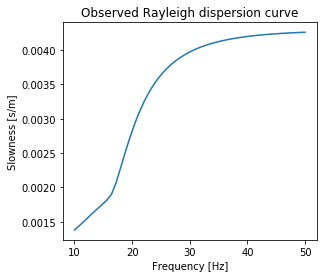

In [2]:
# Define the model
nLayers = 4
h = np.zeros(nLayers, dtype=np.float64)
vp = np.zeros(nLayers, dtype=np.float64)
vs = np.zeros(nLayers, dtype=np.float64)
rho = np.zeros(nLayers, dtype=np.float64)

# Thickness
h[0] = 5.0; h[1] = 5.0; h[2] = 5.0

# S-wave and P-wave velocities
vs[0] = 250.0; vs[1] = 500.0; vs[2]=750.; vs[3]= 1000.
vp[:] = 2.*vs[:]

# Density
rho[:] = 2000.

# Frequency sample
nSamples = 51
omega = np.linspace(10., 50., 51)
omega *= 2.*np.pi

# Mode and output type
nModes = 1
group = 0

# Initialize output array
slowness = np.zeros((nSamples*nModes), dtype=np.float64)

# Initialize Geopsy-gpdc
gpdc_init(0)

# Calculate theoretical Rayleigh dispersion curve
gpdc_rayleigh(nLayers, h, vp, vs, rho, nSamples, omega, nModes, slowness, group)

# Plot observed dispersion curve
fig = plt.figure(figsize=(10,4))
plt.subplot(121)
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Slowness [s/m]')
plt.title(r'Observed Rayleigh dispersion curve')
plt.plot(omega/(2.*np.pi), slowness)
plt.show();

## Particle Swarm Optimization

In [3]:
# Initialize the swarm class
swarm = Swarm()

# PSO parameters
ngen = 100
nindv = 20
fit = np.zeros((ngen+1, 2), dtype=np.float32)

# Get the search-space from file
# Here, only thickness and S-wave velocities are searched
swarm.init_pspace('data/gpdc_pso_pspace.ascii')

# Initialize particles
swarm.init_particles(nindv)

In [4]:
# First evaluation
hcalc = np.zeros(nLayers, dtype=np.float64)
vpcalc = np.zeros(nLayers, dtype=np.float64)
vscalc = np.zeros(nLayers, dtype=np.float64)
slowcalc = np.zeros((nSamples*nModes), dtype=np.float64)
for indv in range(0, nindv):
    # From particle to model parameters
    hcalc[:] = swarm.current[indv, :, 0]
    vscalc[:] = swarm.current[indv, :, 1]
    vpcalc[:] = 2.*vs[:]
    # Calculate the corresponding dispersion curve
    slowcalc[:] = 0.
    gpdc_rayleigh(nLayers, hcalc, vpcalc, vscalc, rho, nSamples, omega, nModes, slowcalc, group)
    # Calculate the misfit
    L2 = 0.
    for iw in range(0, len(slowcalc)):
        L2 += (slowness[iw]-slowcalc[iw])**2
    # Store the misfit value and the history of each particle
    swarm.misfit[indv] = L2
    swarm.history[indv, :, :] = swarm.current[indv, :, :]
    
# Get the minimum and the mean misfits of the swarm
fit[0, 0] = np.amin(swarm.misfit)
fit[0, 1] = np.mean(swarm.misfit)

In [5]:
# Loop over generations
for igen in range(0, ngen):
    
    # Update the particles using the constriction factor
    # and the toroidal topology
    swarm.update(control=1, topology='toroidal', ndim=4)
    
    # Evaluation
    for indv in range(0, nindv):
        
        # From particle to model parameters
        hcalc[:] = swarm.current[indv, :, 0]
        vscalc[:] = swarm.current[indv, :, 1]
        vpcalc[:] = 2.*vs[:]
        
        # Calculate the corresponding dispersion curve
        slowcalc[:] = 0.
        gpdc_rayleigh(nLayers, hcalc, vpcalc, vscalc, rho, nSamples, omega, nModes, slowcalc, group)
        
        # Calculate the misfit
        L2 = 0.
        for iw in range(0, len(slowcalc)):
            L2 += (slowness[iw]-slowcalc[iw])**2
            
        # If misfit is lower, store the misfit value of each particle
        # and particle history
        if L2 < swarm.misfit[indv]:
            swarm.misfit[indv] = L2
            swarm.history[indv, :, :] = swarm.current[indv, :, :]
        
    # Get the minimum and the mean misfits of the swarm
    fit[igen, 0] = np.amin(swarm.misfit)
    fit[igen, 1] = np.mean(swarm.misfit)

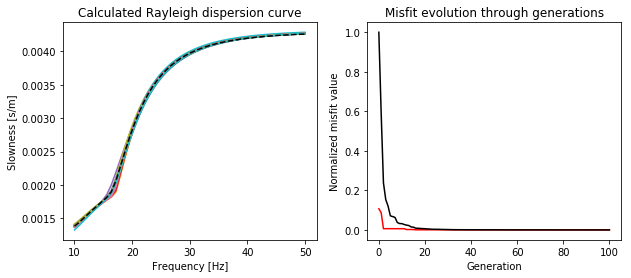

In [8]:
# Plot the best dispersion curves from particles history
fig1 = plt.figure(figsize=(10,4))
plt.subplot(121)
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Slowness [s/m]')
plt.title(r'Calculated Rayleigh dispersion curve')
for indv in range(0, nindv):
    # From particle history to model parameters
    hcalc[:] = swarm.current[indv, :, 0]
    vscalc[:] = swarm.current[indv, :, 1]
    vpcalc[:] = 2.*vs[:]
        
    # Calculate the corresponding dispersion curve
    slowcalc[:] = 0.
    gpdc_rayleigh(nLayers, hcalc, vpcalc, vscalc, rho, nSamples, omega, nModes, slowcalc, group)
    plt.plot(omega/(2.*np.pi), slowcalc)
    
# Plot the observed dispersion curve
plt.plot(omega/(2.*np.pi), slowness, linestyle='--', color='black')

plt.subplot(122)
plt.xlabel(r'Generation')
plt.ylabel(r'Normalized misfit value')
plt.title(r'Misfit evolution through generations')
plt.plot(fit[:,0]/np.amax(fit), color='red')
plt.plot(fit[:,1]/np.amax(fit), color='black')
plt.show();

In [7]:
# Get the best particle of the swarm
ibest = np.argmin(swarm.misfit)
print(swarm.history[ibest, :, :])

[[   4.9232965  249.41708  ]
 [   4.603553   477.5197   ]
 [   6.5383964  750.96954  ]
 [   0.        1009.3545   ]]
